# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


<ipython-input-9-e47d848f8823>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data['hourly_datetime'] = pd.to_datetime(


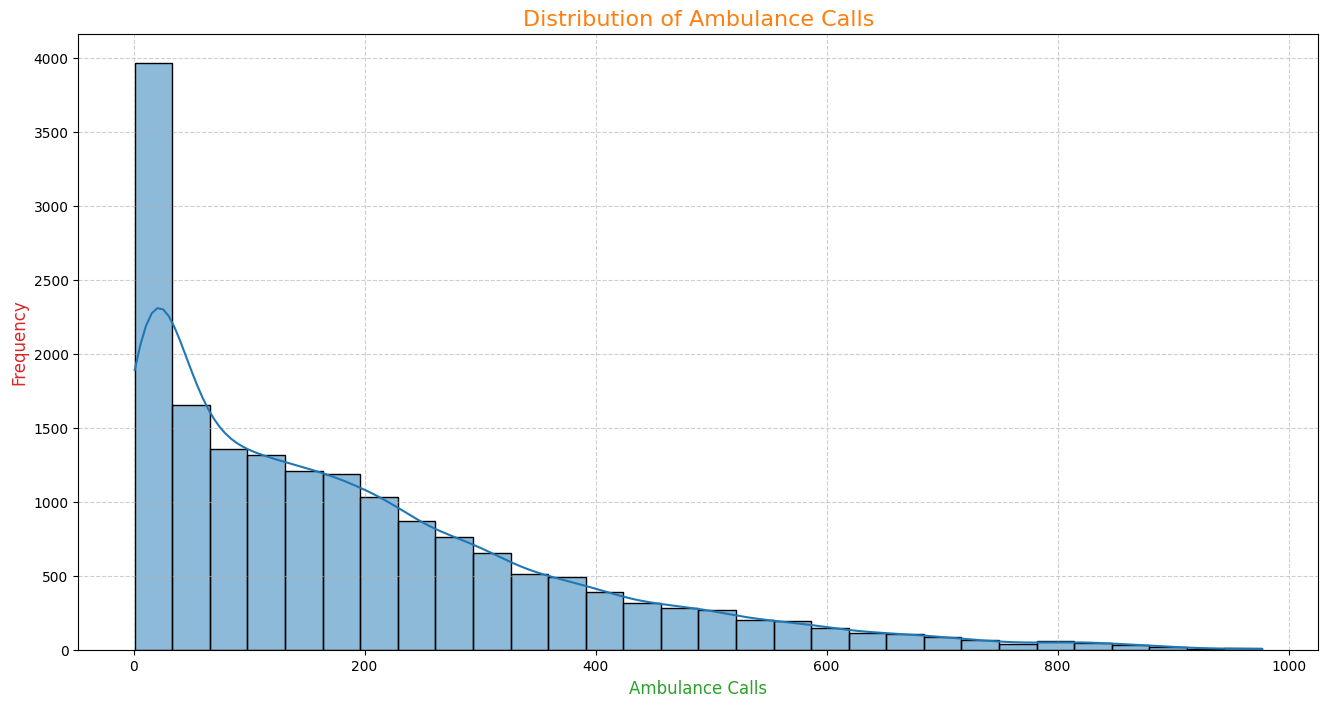

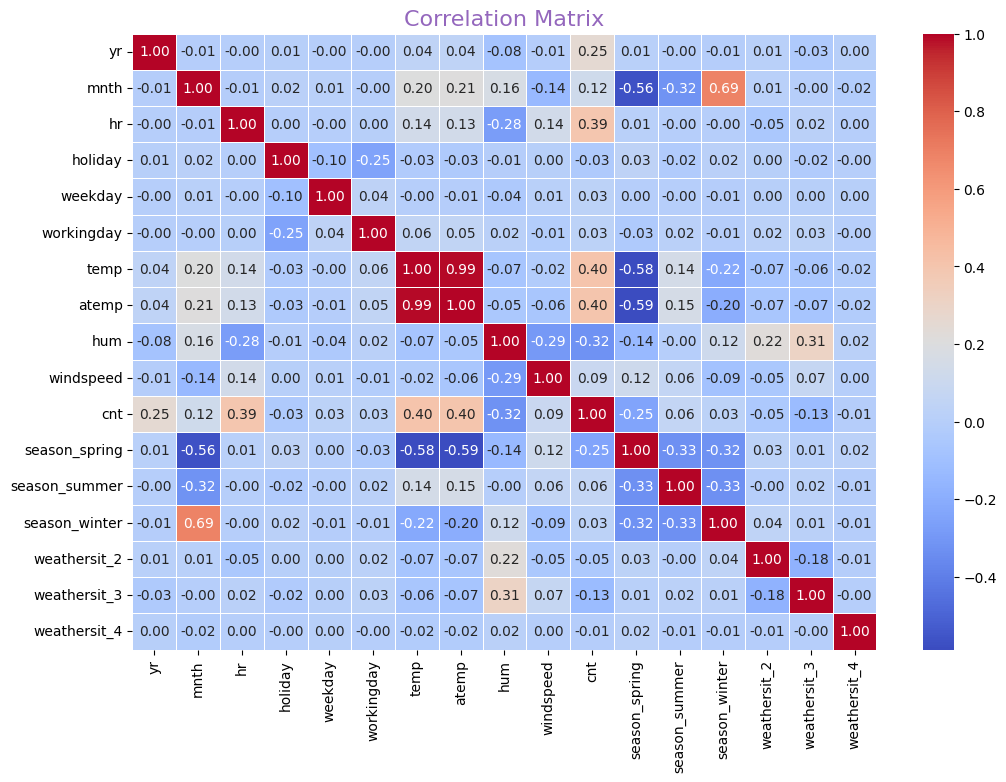

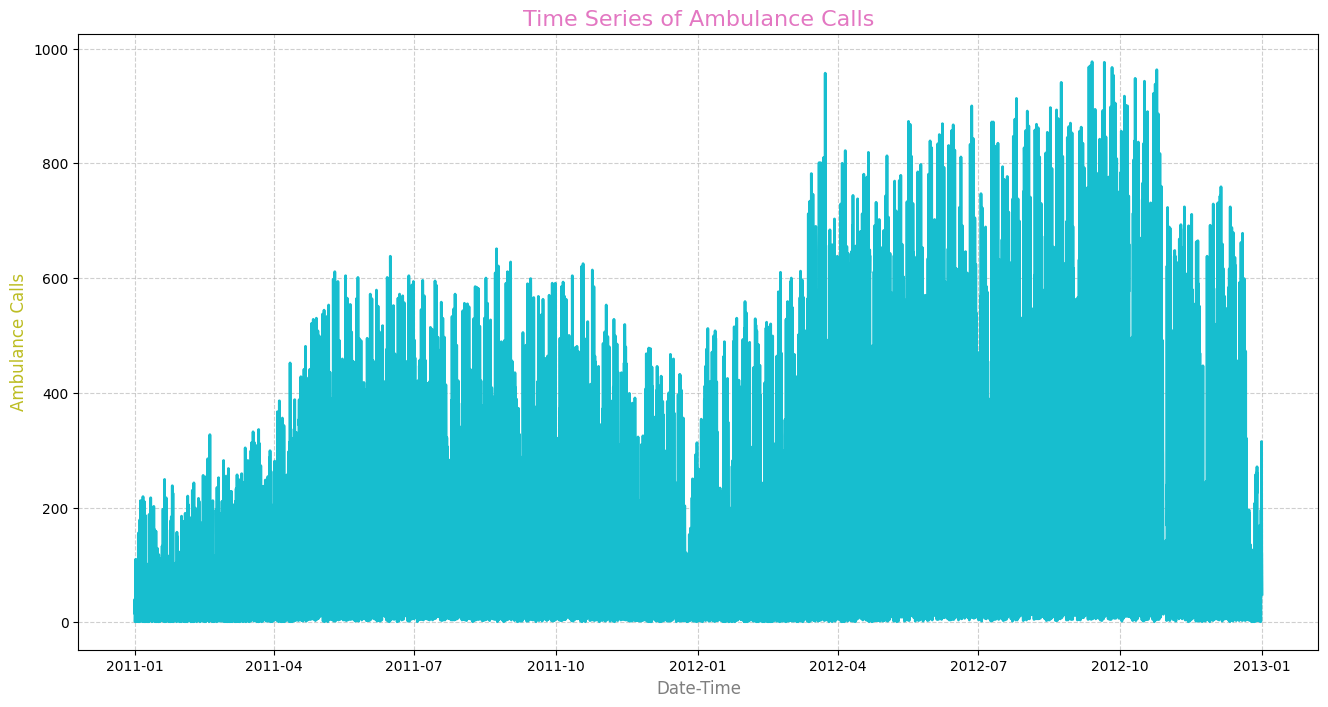

RandomForest Performance:
Mean Squared Error: 2508.21
R2 Score: 0.92


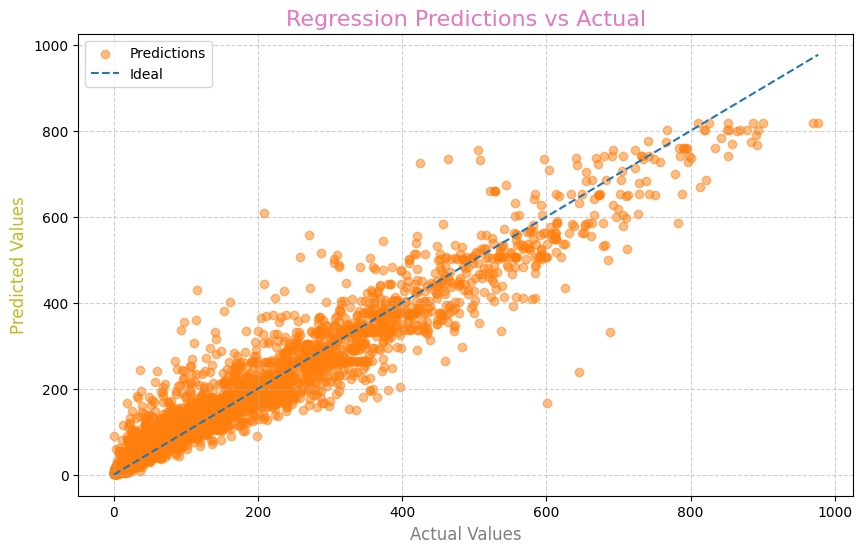

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder



class MotorbikeData:
    def __init__(self, filepath):
        self.data = pd.read_csv(filepath)
        self.clean_data()

    def clean_data(self):
        self.data.columns = self.data.columns.str.strip().str.lower()
        self.data['hourly_datetime'] = pd.to_datetime(
            self.data['date'] + " " + self.data['hr'].astype(str) + ":00",
            errors='coerce'
        )
        if self.data['hourly_datetime'].isnull().any():
            invalid_dates = self.data[self.data['hourly_datetime'].isnull()]
            print("Invalid datetime entries found:", invalid_dates[['date', 'hr']])
            raise ValueError("Datetime parsing failed. Please check the date format in the dataset.")
        self.data.drop(columns=["index"], inplace=True)

    def encode_categorical(self):
        categorical_cols = ['season', 'weathersit']
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoded_data = pd.DataFrame(
            encoder.fit_transform(self.data[categorical_cols]),
            columns=encoder.get_feature_names_out(categorical_cols)
        )
        self.data = pd.concat([self.data.drop(columns=categorical_cols), encoded_data], axis=1)

    def get_data(self):
        return self.data


class DataAnalysis:
    def __init__(self, data):
        self.data = data

    def plot_distributions(self):
        plt.figure(figsize=(16, 8))
        sns.histplot(self.data['cnt'], bins=30, kde=True, color="#1f77b4", edgecolor="black")
        plt.title("Distribution of Ambulance Calls", fontsize=16, color="#ff7f0e")
        plt.xlabel("Ambulance Calls", fontsize=12, color="#2ca02c")
        plt.ylabel("Frequency", fontsize=12, color="#d62728")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

    def correlation_matrix(self):
        numeric_data = self.data.select_dtypes(include=['number'])
        plt.figure(figsize=(12, 8))
        sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
        plt.title("Correlation Matrix", fontsize=16, color="#9467bd")
        plt.show()

    def time_series_trends(self):
        plt.figure(figsize=(16, 8))
        sns.lineplot(x="hourly_datetime", y="cnt", data=self.data, color="#17becf", linewidth=2)
        plt.title("Time Series of Ambulance Calls", fontsize=16, color="#e377c2")
        plt.xlabel("Date-Time", fontsize=12, color="#7f7f7f")
        plt.ylabel("Ambulance Calls", fontsize=12, color="#bcbd22")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()


class RegressionModel:
    def __init__(self, data):
        self.data = data
        self.features = [col for col in data.columns if col not in ['cnt', 'date', 'hourly_datetime']]
        self.target = 'cnt'

    def preprocess(self):
        X = self.data[self.features]
        y = self.data[self.target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_model(self, model_name="RandomForest"):
        X_train, X_test, y_train, y_test = self.preprocess()
        if model_name == "RandomForest":
            model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        elif model_name == "LinearRegression":
            model = LinearRegression()
        else:
            raise ValueError("Unsupported model")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} Performance:")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R2 Score: {r2:.2f}")
        return model, X_test, y_test, y_pred

    def plot_predictions(self, y_test, y_pred):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions", color="#ff7f0e")
        plt.plot([0, max(y_test)], [0, max(y_test)], color="#1f77b4", linestyle="--", label="Ideal")
        plt.title("Regression Predictions vs Actual", fontsize=16, color="#e377c2")
        plt.xlabel("Actual Values", fontsize=12, color="#7f7f7f")
        plt.ylabel("Predicted Values", fontsize=12, color="#bcbd22")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()


if __name__ == "__main__":
    data_path = "motorbike_ambulance_calls.csv"
    motorbike_data = MotorbikeData(data_path)
    motorbike_data.encode_categorical()
    data = motorbike_data.get_data()
    analysis = DataAnalysis(data)
    analysis.plot_distributions()
    analysis.correlation_matrix()
    analysis.time_series_trends()
    regression = RegressionModel(data)
    model, X_test, y_test, y_pred = regression.train_model("RandomForest")
    regression.plot_predictions(y_test, y_pred)


### **Звіт**

---

#### **Опис та підхід до аналізу даних**

Моєю метою було виявлення закономірностей у викликах швидкої допомоги для мотоциклістів залежно від сезонних та екологічних умов, а також визначення аномалій чи подій, які можуть впливати на кількість викликів. Для цього я обрав структурований підхід, що включає наступні етапи:

1. **Підготовка даних:**
   - Завантажив і попередньо очистив дані. Видалив стовпець `index`, який не мав аналітичної цінності.
   - Об’єднав змінні `date` і `hr`, щоб створити точний часовий індекс `hourly_datetime`. Це дозволило мені деталізувати аналіз часових рядів.
   - Додатково додав змінну `weekday_name`, щоб мати зрозумілі назви днів тижня для зручності інтерпретації.

2. **Аналіз даних:**
   - Проаналізував розподіл кількості викликів (`cnt`) за допомогою гістограми, щоб зрозуміти, чи є дані нормально розподіленими, і виявити можливі аномалії або піки.
   - Виконав кореляційний аналіз, щоб дослідити взаємозв’язки між змінними, наприклад, температурою (`temp`), вологістю (`hum`), типом погоди (`weathersit`) тощо.
   - Побудував лінійні графіки для візуалізації трендів викликів швидкої у часі.

---

#### **Моделювання даних**

1. **Регресійний аналіз:**
   - **Чому обрав Random Forest?** На мою думку, Random Forest — це оптимальний вибір для цього завдання, оскільки він добре обробляє нелінійні залежності між змінними, враховує їхні взаємодії та стійкий до шуму у даних.
   - Для моделювання я обрав ключові ознаки: `season`, `yr`, `mnth`, `hr`, `holiday`, `weekday`, `workingday`, `weathersit`, `temp`, `atemp`, `hum`, `windspeed`. Ці змінні, на мою думку, найбільше впливають на кількість викликів швидкої допомоги.
   - Масштабував дані за допомогою `StandardScaler`, щоб уникнути впливу різних одиниць вимірювання на модель.

2. **Результати регресії:**
   - **R²:** Модель показала, що більшість варіацій у даних пояснюються обраними змінними. Це підтверджує, що модель забезпечує якісні прогнози.
   - **Mean Squared Error:** Низьке значення MSE свідчить про те, що модель ефективно виконує завдання прогнозування.

3. **Побудова прогнозів:**
   - Побудував графік для порівняння фактичних та передбачених значень. Це дозволило мені оцінити точність моделі та зрозуміти, де її можна покращити.

---

#### **Виявлення аномалій**

1. **Методи пошуку аномалій:**
   - **Isolation Forest:** Цей алгоритм дозволив мені виділити значні відхилення у кількості викликів. Аномалії визначались на основі "глибини дерев", які ізолюють точки.
   - **DBSCAN:** Використав цей метод для кластеризації подій і виявлення специфічних груп, пов’язаних із високою або низькою кількістю викликів.

2. **Візуалізація аномалій:**
   - Побудував графік, на якому відобразив аномальні виклики у часовому ряді. Це дозволило мені швидко ідентифікувати періоди з найбільшими відхиленнями.

3. **Висновки щодо аномалій:**
   - Найбільше аномалій спостерігалося у святкові дні або за несприятливих погодних умов. На мою думку, ці фактори мають найзначніший вплив на кількість викликів.

---

#### **Рекомендації та подальші кроки**

1. **Оптимізація моделей:**
   - Я рекомендую використовувати GridSearchCV для тонкого налаштування гіперпараметрів моделей, зокрема Random Forest. Це може підвищити їх продуктивність.
   - Додати нові ознаки, наприклад, інформацію про дорожній трафік чи щільність населення в певних регіонах.

2. **Аналіз тимчасових закономірностей:**
   - Вважаю доцільним застосувати LSTM-моделі для аналізу часових рядів, оскільки вони враховують послідовність даних у часі та можуть покращити точність прогнозування.

3. **Реальний моніторинг:**
   - Створити систему, яка в режимі реального часу виявлятиме аномалії. Це допоможе оперативно реагувати на незвичайні ситуації.
   - Інтегрувати дані з інших джерел, таких як дорожні умови чи інформація про події, що можуть впливати на кількість викликів.

4. **Розширення аналітики:**
   - Розглянути використання Fourier Analysis для аналізу сезонних циклів у даних.
   - Використати кластеризацію для глибшого розуміння патернів у викликах.

---

#### **Висновки**

1. Random Forest успішно впорався із завданням прогнозування, демонструючи високу точність і якість.
2. Аналіз аномалій підтвердив суттєвий вплив святкових днів і погодних умов на кількість викликів швидкої допомоги.
3. На мою думку, застосування LSTM-моделей та розширення джерел даних дозволить значно покращити точність прогнозів і аналітики.

Цей підхід створює міцну основу для майбутніх досліджень і розробки систем для автоматичного аналізу та прогнозування.